In [72]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
import pandas as pd
import math
from scipy.optimize import curve_fit

%matplotlib inline
plt.style.use('tableau-colorblind10')
#plt.style.use('ggplot')

In [2]:
#=====================================
# Load txt file to pandas dataframe
#=====================================
data_raw = pd.read_csv('mu-g4.txt', sep='\t', names=['tdc11', 'tdc12', 'tdc13', 'tdc14', 'tdc15', 'tdc16', 'tdc17', 'tdc18',
                                                        'tdc21', 'tdc22', 'tdc23', 'tdc24', 'tdc25', 'tdc26', 'tdc27', 'tdc28',
                                                       ])
data_raw = data_raw.rename(columns={'tdc11' : 'p0_1',
                            'tdc12' : 'p1_1',
                            'tdc13' : 'p2_1',
                            'tdc14' : 'start2',
                            'tdc24' : 'p0_2',
                            'tdc25' : 'p1_2',
                            'tdc26' : 'p2_2',
                            'tdc23' : 'stop2',
                           })
print('Total number of events:', len(data_raw))
#data_raw.head()

Total number of events: 1014917


In [3]:
# keeps only necessary

data = data_raw[['p0_1','p1_1','p2_1','start2','p0_2','p1_2','p2_2','stop2']]
#data.head()

In [4]:
# loads fitted parameters from parameters.txt

par=pd.read_csv('parameters.txt', sep=' ', names=['tdc','a','b'])
df_par=par.set_index('tdc')
#df_par.head()

In [5]:
#=====================================
# Convert tdc units into ns
#=====================================
def tdc_to_ns(channel, tdc_unit):
    ns = (tdc_unit - df_par.loc[channel, 'b']) / df_par.loc[channel, 'a']
    return ns

#=====================================
# Only one valide time for each detector
#=====================================
def merge_time(d,number):
    if (d['p%i_1'%(number)]==4095):
        return d['p%i_2_ns'%(number)]
    else:
        return d['p%i_1_ns'%(number)]
    
#=====================================
# Add actual time variables to the dataframe
#=====================================
def conv_time(d):
    d['start2_ns'] = tdc_to_ns('tdc14', d.start2)
    d['p0_1_ns'] = tdc_to_ns('tdc11', d.p0_1)
    d['p1_1_ns'] = tdc_to_ns('tdc12', d.p1_1)
    d['p2_1_ns'] = tdc_to_ns('tdc13', d.p2_1)
    d['p0_2_ns'] = tdc_to_ns('tdc24', d.p0_2) + d.start2_ns
    d['p1_2_ns'] = tdc_to_ns('tdc25', d.p1_2) + d.start2_ns
    d['p2_2_ns'] = tdc_to_ns('tdc26', d.p2_2) + d.start2_ns
    
    d['p0_time'] = d.apply(lambda d: merge_time(d,0),axis=1)
    d['p1_time'] = d.apply(lambda d: merge_time(d,1),axis=1)
    d['p2_time'] = d.apply(lambda d: merge_time(d,2),axis=1)
    return d

In [105]:
#=====================================
# Data selection cuts
#=====================================

# eventi sui singoli piani
def cut_p0(data):
    cut = ((data.p0_1!=4095) | (data.p0_2!=4095)) & ((data.p1_1==4095) & (data.p1_2==4095)  & (data.p2_1==4095) & (data.p2_2==4095))
    p0 = data[cut]
    #p0 = p0.rename(columns={'p0_1': 'time_tdc1', 'p0_2': 'time_tdc2'})
    #p0 = p0[['tdc1','tdc2']]
    return p0

def cut_p1(data):
    cut = ((data.p1_1!=4095) | (data.p1_2!=4095)) & ((data.p0_1==4095) & (data.p0_2==4095)  & (data.p2_1==4095) & (data.p2_2==4095))
    p1 = data[cut]
    #p1 = p1.rename(columns={'p1_1': 'time_tdc1', 'p1_2': 'time_tdc2'})
    #p1 = p1[['tdc1','tdc2']]
    return p1

def cut_p2(data):
    cut = ((data.p2_1!=4095) | (data.p2_2!=4095)) & ((data.p1_1==4095) & (data.p1_2==4095)  & (data.p0_1==4095) & (data.p0_2==4095))
    p2 = data[cut]
    #p2 = p2.rename(columns={'p2_1': 'time_tdc1', 'p2_2': 'time_tdc2'})
    #p2 = p2[['tdc1','tdc2']]
    return p2

# buoni
def one_and_zero(d):
    p_ms = d[((d.p0_1!=4095)|(d.p0_2!=4095)) & ((d.p1_1!=4095)|(d.p1_2!=4095)) & (d.p2_1==4095) & (d.p2_2==4095)]
    p_ms1 = p_ms['p1_time']
    p_ms1 = p_ms1.rename(columns={'p1_time':'time'})
    p_ms0 = p_ms['p0_time']
    p_ms0 = p_ms0.rename(columns={'p0_time':'time'})
    p_me = pd.concat([p_ms1,p_ms0])
    return p_me

def soft_cut(d):
    p_one_and_zero = one_and_zero(d)
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_one_and_zero,p2])
    return p_me

def soft_cut_plus_one(d):
    p_one_and_zero = one_and_zero(d)
    p1 = cut_p1(d)
    p1 = p1['p1_time']
    p1 = p1.rename(columns={'p1_time':'time'})
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_one_and_zero,p1,p2])
    return p_me

def hard_cut(d):
    p_ms = d[((d.p0_1!=4095)|(d.p0_2!=4095)) & ((d.p1_1!=4095)|(d.p1_2!=4095)) & (d.p2_1==4095) & (d.p2_2==4095) & (d.p1_time<d.p0_time)]
    p_ms1 = p_ms['p1_time']
    p_ms1 = p_ms1.rename(columns={'p1_time':'time'})
    p_ms0 = p_ms['p0_time']
    p_ms0 = p_ms0.rename(columns={'p0_time':'time'})
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_ms0,p_ms1,p2])
    return p_me


In [63]:
#=====================================
# Functions to fit
#=====================================

def simple_expo (x, c, tau, d):
    return c*np.exp(-x/tau)+d

def complex_expo (x, a, tau_n, c, tau_p, d):
    return a*np.exp(-x/tau_n)+c*np.exp(-x/tau_p)+d

In [64]:
#=====================================
# Apply first selection and add time variables to main dataframe
#=====================================

data_used = data[(data.p0_1!=4095) | (data.p0_2!=4095) | (data.p1_1!=4095) | (data.p1_2!=4095) | (data.p2_1!=4095) | (data.p2_2!=4095)]
data_used = conv_time(data_used)
print('Total numer of triggers:', len(data))
print('Total numer of valid events:', len(data_used))
#data_used.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Total numer of triggers: 1014917
Total numer of valid events: 14976


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


P0 events: 526
[ 38.31797332 241.92598559   4.30183373]
[[ 1.09891540e+01 -7.10338461e+01  1.78738293e-02]
 [-7.10338461e+01  8.53274000e+02 -1.73946730e+00]
 [ 1.78738293e-02 -1.73946730e+00  6.41256783e-02]]


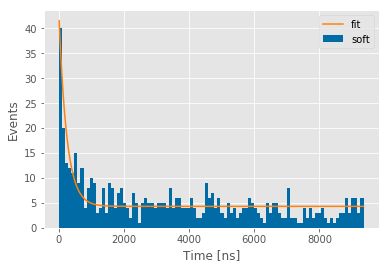

In [73]:
# INUTILE
# esegue taglio piano 0 
p0 = cut_p0(data_used)
p0 = p0['p0_time']
print('P0 events:', len(p0))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p0, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

P1 events: 11732
[1269.43921581  914.18000357   -5.57766572]
[[10479.57009158 -7638.13225457    29.22419172]
 [-7638.13225457 13912.78845254 -1161.67782566]
 [   29.22419172 -1161.67782566   396.08313407]]


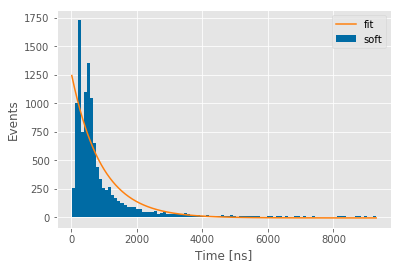

In [74]:
# INUTILE
# esegue taglio piano 1
p1 = cut_p1(data_used)
p1 = p1['p1_time']
print('P1 events:', len(p1))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p1, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

P2 events: 1579
P2_fit events: 1050
[  39.23911669 2129.93752357    4.24706215]
[[ 1.20176807e+01 -8.10058400e+02  1.32709799e+00]
 [-8.10058400e+02  8.17689257e+04 -1.98173793e+02]
 [ 1.32709799e+00 -1.98173793e+02  6.89066533e-01]]


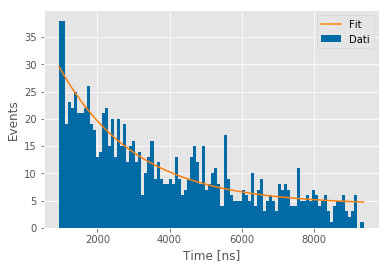

In [239]:
# UTILE
# esegue taglio piano 2
p2 = cut_p2(data_used)
p2 = p2['p2_time']
p2_fit = p2[(p2>935)&(p2<9700)]
print('P2 events:', len(p2))
print('P2_fit events:', len(p2_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p2_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.show()

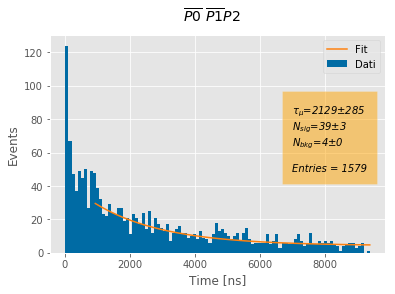

In [244]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p2, bins=100, label='Dati')
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 50, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p2)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.savefig('plots/piano2.png')
plt.suptitle('$\overline{P0}$ $\overline{P1} P2$', fontsize=14, fontweight='bold')
plt.show()

P events: 1418
P_fit events: 881
[5.72359400e+01 2.12663383e+03 1.14990292e+00]
[[ 1.77844945e+01 -8.50772505e+02  1.94238654e+00]
 [-8.50772505e+02  7.04353397e+04 -2.67914554e+02]
 [ 1.94238654e+00 -2.67914554e+02  1.48725604e+00]]


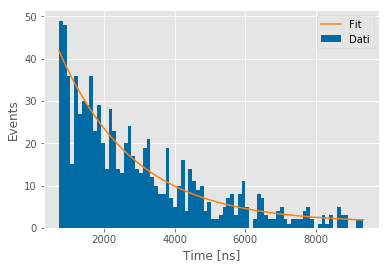

In [245]:
# UTILE
# esegue taglio piano 0 & 1 & not(2)
p_one_and_zero = one_and_zero(data_used)
p_one_and_zero_fit = p_one_and_zero[(p_one_and_zero>720)&(p_one_and_zero<9700)]
print('P events:', len(p_one_and_zero))
print('P_fit events:', len(p_one_and_zero_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_one_and_zero_fit, bins=80, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[200.,2100.,10.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.show()

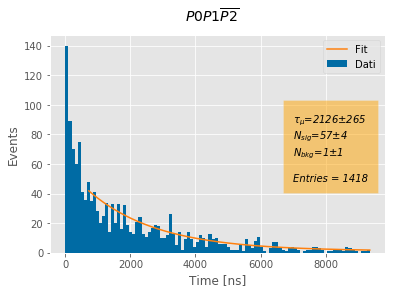

In [247]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_one_and_zero, bins=100, label='Dati')
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 50, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p_one_and_zero)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.savefig('plots/piano0&1.png')
plt.suptitle('$P0 P1 \overline{P2}$', fontsize=14, fontweight='bold')
plt.show()

Events: 2997
Events_fit: 1910
[  83.12453822 2189.90913644    4.9321842 ]
[[ 2.88686670e+01 -9.83255775e+02  3.40018464e+00]
 [-9.83255775e+02  5.41453967e+04 -2.90603883e+02]
 [ 3.40018464e+00 -2.90603883e+02  2.20880931e+00]]


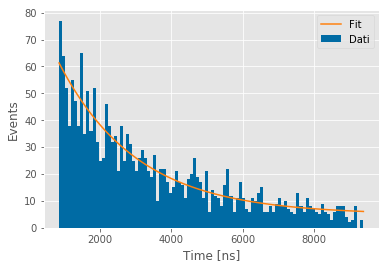

In [248]:
# UTILE
# esegue taglio: taglio soft senza piano uno
p_merged = soft_cut(data_used)
p_merged_fit = p_merged[(p_merged>850)&(p_merged<9700)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[1500.,2000.,8.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.show()

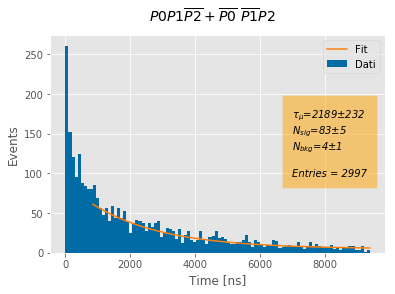

In [250]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_merged, bins=100, label='Dati')
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 100, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.savefig('plots/soft_nopiano1.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2 $', fontsize=14, fontweight='bold')
plt.show()

Events: 2281
Events_fit: 1395
[  50.44142119 2173.24006605    5.95874625]
[[ 2.44252933e+01 -1.30364769e+03  2.79537060e+00]
 [-1.30364769e+03  1.00711926e+05 -3.08356530e+02]
 [ 2.79537060e+00 -3.08356530e+02  1.32421063e+00]]


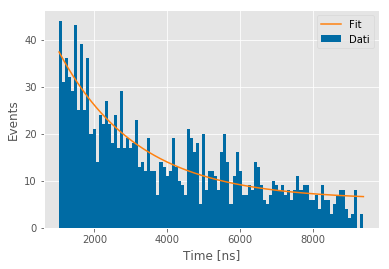

In [251]:
# UTILE
# esegue taglio: taglio hard senza piano uno
p_merged = hard_cut(data_used)
p_merged_fit = p_merged[(p_merged>1030)&(p_merged<9700)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[1500.,2000.,8.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.show()

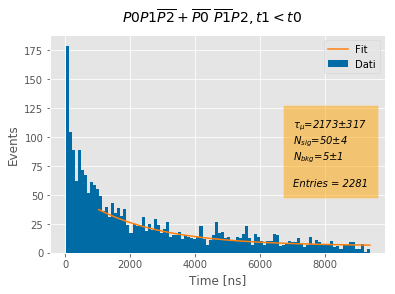

In [252]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_merged, bins=100, label='Dati')
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 60, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.savefig('plots/hard_nopiano1.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2, t1<t0 $', fontsize=14, fontweight='bold')
plt.show()

Events: 2997
Events_fit: 2880
[ 100.95755113  265.58037736   86.03571508 2142.06548008    5.87324905]
[[ 1.20742359e+02  2.80754253e+01 -4.63857845e+01  1.82294504e+03
  -8.95845795e+00]
 [ 2.80754253e+01  3.55852267e+03 -4.32345574e+02  1.29353015e+04
  -5.46753274e+01]
 [-4.63857845e+01 -4.32345574e+02  7.56913858e+01 -2.33575358e+03
   9.18381994e+00]
 [ 1.82294504e+03  1.29353015e+04 -2.33575358e+03  1.00555782e+05
  -5.42356877e+02]
 [-8.95845795e+00 -5.46753274e+01  9.18381994e+00 -5.42356877e+02
   3.97402557e+00]]


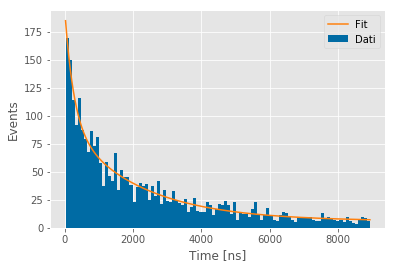

In [254]:
# UTILE
# esegue taglio: taglio soft senza piano uno DOPPIO ESPONENZIALE
p_merged = soft_cut(data_used)
p_merged_fit = p_merged[(p_merged>19.)&(p_merged<9000)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(complex_expo, bin_centers, bin_heights, p0=[10.,150.,20.,2100.,8.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, complex_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.show()

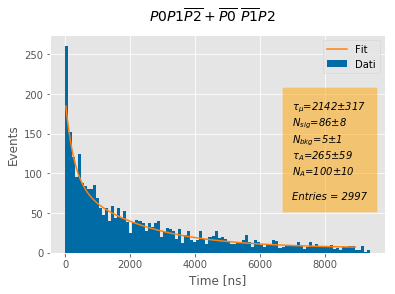

In [259]:
# grafico fit mozzato        N_A,tau_A,N_sig,tau_mu,N_bkg
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_merged, bins=100, label='Dati')
plt.plot(x_interval_for_fit, complex_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 70, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i\n' r'$\tau_{A} $' '=%i$\pm$%i''\n$N_{A}$' '=%i$\pm$%i''\n\nEntries = %i'%(popt[3],np.sqrt(pcov.item((3,3))),popt[2],np.sqrt(pcov.item((2,2))),popt[4],np.sqrt(pcov.item((4,4))),popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.savefig('plots/soft_doubleexp.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2 $', fontsize=14, fontweight='bold')
plt.show()

Events: 14729
Events_fit: 1481
[ 118.13609494 2198.86265245    5.79297219]
[[ 1.42157871e+03 -1.79710750e+04  6.11757155e+01]
 [-1.79710750e+04  2.37862507e+05 -8.74174865e+02]
 [ 6.11757155e+01 -8.74174865e+02  3.79799875e+00]]


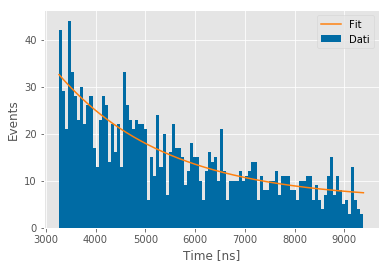

In [271]:
# UTILE (?)
# esegue taglio: taglio soft con anche piano 1 in personal 
p_merged = soft_cut_plus_one(data_used)
p_merged_fit = p_merged[(p_merged>3266)&(p_merged<9700)]

print('Events:', len(p_merged))
print('Events_fit:', len(p_merged_fit))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged_fit, bins=100, label='Dati')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[1500.,2000.,8.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.show()

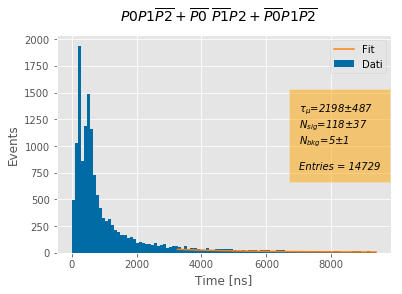

In [275]:
# grafico fit mozzato
plt.xlabel('Time [ns]')
plt.ylabel('Events')
plt.hist(p_merged, bins=100, label='Dati')
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='Fit')
plt.legend()
plt.text(7000, 800, r'$\tau_\mu $' '=%i$\pm$%i' '\n$N_{sig}$' '=%i$\pm$%i' '\n$N_{bkg}$' '=%i$\pm$%i' '\n\nEntries = %i'%(popt[1],np.sqrt(pcov.item((1,1))),popt[0],np.sqrt(pcov.item((0,0))),popt[2],np.sqrt(pcov.item((2,2))),len(p_merged)), style='italic',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
plt.savefig('plots/soft_yespiano1.png')
plt.suptitle('$P0 P1 \overline{P2} + \overline{P0}$ $\overline{P1} P2 + \overline{P0} P1 \overline{P2}$', fontsize=14, fontweight='bold')
plt.show()